In [2]:
# Project 1 v2
# Trying a different approach
# first read the image, use orb on it no matter what, split the table 
# then draw the lines or draw the x directly


In [364]:
# imports
# Required libraries to be installed: Pillow, OpenCV
import cv2 as cv
import numpy as np
import glob
import os
import pickle
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, display
import PIL.Image
import io

In [365]:
base_folder = './Simulation/' # change this on your machine
# images_n = glob.glob(os.path.join(base_folder, "image_*.jpg")) 
# images_r = glob.glob(os.path.join(base_folder, "rotation_*.jpg")) 
# images_p = glob.glob(os.path.join(base_folder, "perspective_*.jpg")) 

# normal_images = glob.glob(os.path.join("./warped/", "image_*.jpg")) 
# rotated_images = glob.glob(os.path.join("./warped_rotated/", "rotation_*.jpg")) 
# perspective_images = glob.glob(os.path.join("./warped_perspective/", "perspective_*.jpg")) 
template_images = glob.glob(os.path.join('./', "template_*.jpg")) 
char_to_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [366]:
# helper functions
def show_image(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def read_image(index, source, resize):
    image = cv.imread(source[index])
    return cv.resize(image, (0, 0), fx=resize, fy=resize)

In [367]:
# helper variables
template_image = read_image(0, template_images, 1)
template_image = cv.resize(template_image, (0, 0), fx=0.6, fy=0.6)
h, w, _ = template_image.shape
template_image = template_image[int(0.36 * h):h, :]
# show_image(template_image)

In [348]:
def get_options_grid(image):
    h, w, _ = image.shape
    options_grid = image[int(0.163 * h):int(0.24 * h), int(0.86 * w): int(0.89 * w)]
    return options_grid

def get_selected_grid(grid):
    x_color = (0, 255, 0)  # plot a patch containing an X with green color
    blank_color = (0, 0, 255)  # plot a patch containing a blank with red color 
    colors = [blank_color] * 2
    x1_min = 10
    x1_max = 60
    
    x2_min = 10
    x2_max = 60
    
    y1_min = 4
    y1_max = 52
    
    y2_min = 120
    y2_max = 170
    
    
    patch1 = image[y1_min:y1_max,x1_min:x1_max].copy().mean()
    patch2 = image[y2_min:y2_max,x2_min:x2_max].copy().mean()
    patches = [patch1, patch2]
    # Get the indices of maximum element in numpy array
    min_value = min(patches)
    print(min_value)
    index = patches.index(min_value)
    colors[index] = x_color  
    print(index)
    
    
    cv.rectangle(grid, (x1_min, y1_min), (x1_max, y1_max), color=colors[0], thickness=1)
    cv.rectangle(grid, (x2_min, y2_min), (x2_max, y2_max), color=colors[1], thickness=1)
    show_image(grid)
    return index # 0 = I, 1 = F

In [368]:
def get_first_grid(image):
    image_h, image_w, channels = image.shape
    return image[int(0.32 * image_h):int(image_h * 0.78), int(image_w * 0.222): int(image_w * 0.367)]

def get_second_grid(image):
    image_h, image_w, channels = image.shape
    return image[int(0.32 * image_h):int(image_h * 0.79), int(image_w * 0.75): int(image_w * 0.90)]

In [369]:
def warp_image(template, query):
    img1 = template
    img2 = query
    # create ORB object
    orb = cv.ORB_create(nfeatures=10000)
    # get the keypoints and the corresponding descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None) 
    # create BFMatcher object
    # matcher takes normType, which is set to cv2.NORM_L2 for SIFT and SURF, cv2.NORM_HAMMING for ORB, FAST and BRIEF
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des2, des1) # query_image, train_image
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # points template from img1, the template image
    points_template = np.zeros((len(matches), 2), dtype=np.float32)
    # points_query from img2, the query image
    points_query = np.zeros((len(matches), 2), dtype=np.float32)

    for i,m in enumerate(matches):
        points_template[i,:] = kp1[m.trainIdx].pt
        points_query[i,:] = kp2[m.queryIdx].pt

    H,mask = cv.findHomography(points_query, points_template, cv.RANSAC)

    # use homography to get the aligned image 
    height, width, _ = template.shape # the shape with respect to the template image
    aligned_image2 = cv.warpPerspective(query, H, (width, height), flags=cv.INTER_NEAREST)

    return aligned_image2

In [537]:
def find_x_from_table(table):
    table_gray = cv.cvtColor(table, cv.COLOR_BGR2GRAY)
    image = np.dstack((table_gray, table_gray, table_gray))
    x_color = (0, 255, 0)  # plot a patch containing an X with green color
    blank_color = (0, 0, 255)  # plot a patch containing a blank with red color 
    x_positions = [0] * 15
    w, h, _ = image.shape
    cell_height = int(h / 5)
    cell_width = int(w / 4)
    # y6_min putin mai jos (aka mai mare)
    # 11 mai sus (mai mic), 9 mai jos (mai mare)
#     y_mins = [3, 22, 38, 55, 72, 88, 106, 123, 138, 156, 176, 190, 207, 224, 243]
#     y_mins = [5, 24, 40, 57, 74, 90, 108, 125, 140, 158, 178, 192, 209, 226, 245]
    y_mins = [5, 24, 40, 57, 75, 90, 108, 125, 142, 159, 176, 192, 210, 227, 245]
    for i in range(0, 15):
        colors = [blank_color] * 4
            
        y_min = y_mins[i]
        y_max = y_min + 10
            
        x1_min = 4
        x1_max = 20
        
        x2_min = 27
        x2_max = 42
        
        x3_min = 48
        x3_max = 64
        
        x4_min = 71
        x4_max = 84
        
#         x1_min = 4
#         x1_max = 22
        
#         x2_min = 26
#         x2_max = 44
        
#         x3_min = 46
#         x3_max = 66
        
#         x4_min = 68
#         x4_max = 87
        
        patch1 = image[y_min:y_max,x1_min:x1_max].copy().mean()
        patch2 = image[y_min:y_max,x2_min:x2_max].copy().mean()
        patch3 = image[y_min:y_max,x3_min:x3_max].copy().mean()
        patch4 = image[y_min:y_max,x4_min:x4_max].copy().mean()
        patches = [patch1, patch2, patch3, patch4]
        
        # Get the indices of maximum element in numpy array
        min_value = min(patches)
        index = patches.index(min_value)
        colors[index] = x_color
        x_positions[i] = index
        cv.rectangle(image, (x1_min, y_min), (x1_max, y_max), color=colors[0], thickness=1)
        cv.rectangle(image, (x2_min, y_min), (x2_max, y_max), color=colors[1], thickness=1)
        cv.rectangle(image, (x3_min, y_min), (x3_max, y_max), color=colors[2], thickness=1)
        cv.rectangle(image, (x4_min, y_min), (x4_max, y_max), color=colors[3], thickness=1)
# I return both the image and the position so that I can show the image if the positions do not match
    return (x_positions, image)

In [371]:
def verify_result(ground_truth, detected_values):
    for i in range(0, 15):
        if (int(char_to_index[ground_truth[i][1]]) != detected_values[i]):
            return False
    return True

In [372]:
def get_ground_truth_answers(path):
    file_names = glob.glob(os.path.join(path, '*.txt')) 
    phisycs = []
    informatics = np.empty((4,), dtype=object)
    physics = np.empty((4,), dtype=object)
    ground_truth = {}
    for file in file_names:
        data = np.loadtxt(file, dtype=str)
        option = data[0][0]
        variant = int(data[0][1])
        if (option == 'I'):
            informatics[variant - 1] = data[1:-1]
        if (option == 'F'):
            physics[variant - 1] = data[1:-1]
    ground_truth['F'] = physics
    ground_truth['I'] = informatics
    return ground_truth

In [385]:
def get_answers_from_image(image):
    # it gives different results if I apply 0.25 resize directly. The code initially had a different
    # structure where it made sense and I don't have time to change now it since it works
#     show_image(image)
#     warped = warp_image(template_image, image)
#     resized = cv.resize(warped, (0,0), fx=0.5, fy=0.5)
#     resized = cv.resize(image, (0,0), fx=0.5, fy=0.5)
    table1 = get_first_grid(image)
    table2 = get_second_grid(image)
    
    table_x1 = find_x_from_table(table1)
    table_x2 = find_x_from_table(table2)
#     show_image(table_x1[1])
#     show_image(table_x2[1])
    results = table_x1[0] + table_x2[0]   
    return (results, table_x1[1], table_x2[1])


In [504]:
# answers = computed answers from the image
# options = I / F
# variant = 1, 2, 3 or 4

def calculate_grade(answers, ground_truth, option, variant):
    grade = 0
    for i in range (0, 30):
        # variant - 1 so that we map 1..4 to 0..3
        ground_truth_answer = ground_truth[option][variant - 1][i][1] 
        if (answers[i] == char_to_index[ground_truth_answer]):
            grade += 0.3
    return round(grade + 1, 2)

In [375]:
def verify_read_answers(image_number, answers):
    file = os.path.join(base_folder, 'image_%s.txt' % image_number)
    data = np.loadtxt(file, dtype=str)[1:-1]  
    for i in range(0, 30):
        if (char_to_index[data[i][1]] != answers[i]):
            return False
    
    return True

def verify_grade(image_number, grade):
    file = os.path.join(base_folder, 'image_%s.txt' % image_number)
    data = np.loadtxt(file, dtype=str)[-1]  
    if (round(float(data[1]) * 0.3 + 1, 2) != grade):
        return False    
    return True

def verify_grade_file(image_number, grade):
    file = os.path.join(base_folder, 'images_grades_from_text.txt')
    data = np.loadtxt(file, dtype=str)
    read_image_no = int(data[image_number - 1][0])
    read_image_grade = float(data[image_number - 1][1])
    if (image_number != read_image_no):
        print ("SOMETHING IS WRONG")
        return False
    else:
        if (grade != read_image_grade):
            return False
    return True

In [541]:
# Scenario 1
# ground truth, the 8 possible grading scenarios
ground_truth_answers_path = './Files/ground-truth-correct-answers'
ground_truth = get_ground_truth_answers(ground_truth_answers_path)
# images folder
images = glob.glob("./Simulation/scenario_1/*.jpg") 
images.sort(key = lambda x: int(x.split('/')[-1].split('_')[0]))
total = len(images)

# answers file
answers_file = open('dumitriu_andrei_task1.txt', 'w+')
count = 0 # the number of correctly read answers
for i in range(0, total):
    image_name = images[i].split('/')[-1].split('.')[0]
    option = image_name[-2]
    variant = int(image_name[-1])
    image_number = int(images[i].split('/')[-1].split('.')[0].split('_')[0])
#     print(image_name)
#     print(option)
#     print(variant)
#     print(image_number)
    
    image = read_image(i, images, 1)
    warped1 = warp_image(template_image, image)
    warped = warp_image(template_image, warped1)
    resized = cv.resize(warped, (0,0), fx=0.5, fy=0.5)
    image = cv.resize(resized, (0,0), fx=0.5, fy=0.5)
    
    answers = get_answers_from_image(image)[0]
    grade = calculate_grade(answers, ground_truth, option, variant)
    
    written_string = str(image_name + "    " + str(grade))
    answers_file.write(written_string)
    answers_file.write('\n')
    
    # verify, can de deleted afterwards
    verified = verify_grade_file(image_number, grade)
    if (verified == True):
        count += 1
    else:
        print('\n')
        print(image_name, ' ', answers)
        show_image(table1)
        show_image(table2)
        print('\n')
    print(image_name, ' ', grade, ' ', verified)
    # end of deletion
    

answers_file.close()

01_scanned_F1   4.9   True
02_scanned_I3   6.7   True
03_scanned_I1   5.8   True
04_scanned_F3   8.5   True
05_scanned_I2   4.9   True
06_scanned_I4   6.7   True
07_scanned_I2   9.1   True
08_scanned_I1   3.7   True
09_scanned_F4   5.5   True
10_scanned_I1   5.5   True
11_scanned_F1   4.6   True
12_scanned_F3   6.7   True
13_scanned_I4   7.3   True
14_scanned_F1   6.4   True
15_scanned_F1   7.0   True
16_scanned_F4   4.6   True
17_scanned_I1   7.6   True
18_scanned_I2   6.1   True
19_scanned_I1   4.9   True
20_scanned_F1   7.6   True
21_scanned_F3   6.4   True
22_scanned_F4   5.5   True
23_scanned_F4   6.4   True
24_scanned_F2   7.3   True
25_scanned_I4   7.9   True
26_scanned_F2   8.5   True
27_scanned_I3   5.5   True
28_scanned_F3   8.8   True
29_scanned_I2   6.1   True
30_scanned_F1   7.9   True
31_scanned_F2   4.9   True
32_scanned_F1   5.2   True
33_scanned_F1   7.6   True
34_scanned_I3   7.0   True
35_scanned_F1   7.0   True
36_scanned_F2   6.4   True
37_scanned_F3   8.8   True
3

In [529]:

print (count * 100 / total)

100.0


In [539]:
# Scenario 2
# ground truth, the 8 possible grading scenarios
ground_truth_answers_path = './Files/ground-truth-correct-answers'
ground_truth = get_ground_truth_answers(ground_truth_answers_path)
# images folder
images = glob.glob("./Simulation/scenario_2/*.jpg")
images.sort()
total = len(images)
# total = 1

# answers file
answers_file = open('dumitriu_andrei_task2.txt', 'w+')
count = 0 # the number of correctly read answers
for i in range(0, total):
    image_name = images[i].split('/')[-1].split('.')[0]
    option = image_name[-2]
    variant = int(image_name[-1])
    image_number = int(images[i].split('/')[-1].split('.')[0].split('_')[0])
#     print(image_name)
#     print(option)
#     print(variant)
#     print(image_number)
    
    image = read_image(i, images, 1)
    warped1 = warp_image(template_image, image)
    warped = warp_image(template_image, warped1)
    resized = cv.resize(warped, (0,0), fx=0.5, fy=0.5)
    image = cv.resize(resized, (0,0), fx=0.5, fy=0.5)
    
    answers = get_answers_from_image(image)[0]
    
    table1 = get_answers_from_image(image)[1]
    table2 = get_answers_from_image(image)[2]
    
    grade = calculate_grade(answers, ground_truth, option, variant)
    
    written_string = str(image_name + "    " + str(grade))
    answers_file.write(written_string)
    answers_file.write('\n')
    
    # verify, can de deleted afterwards
    verified = verify_grade_file(image_number, grade)
    if (verified == True):
        count += 1
    else:
        print('\n')
        print(image_name, ' ', answers)
        show_image(table1)
        show_image(table2)
        print('\n')
    print(image_name, ' ', grade, ' ', verified)
    # end of deletion

answers_file.close()
print (count * 100 / total)

error: OpenCV(4.2.0) ../modules/imgproc/src/thresh.cpp:1529: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'threshold'


In [492]:
def get_options_grid(image):
    h, w, _ = image.shape
    options_grid = image[int(0.163 * h):int(0.245 * h), int(0.862 * w): int(0.89 * w)]
#     options_grid = image[int(0.163 * h):int(0.245 * h), int(0.56 * w): int(0.89 * w)]
    
#     options_grid = cv.medianBlur(options_grid, 5)
    options_grid = cv.cvtColor(options_grid, cv.COLOR_BGR2GRAY)
    (thresh, options_black_and_white) = cv.threshold(options_grid, 127, 255, cv.THRESH_BINARY)
    return options_black_and_white

def get_selected_grid(grid1):
    x_color = (0, 255, 0)  # plot a patch containing an X with green color
    blank_color = (0, 0, 255)  # plot a patch containing a blank with red color
    
    grid = np.dstack((grid1, grid1, grid1))
    colors = [blank_color] * 2
    x1_min = 10
    x1_max = 50
    
    x2_min = 10
    x2_max = 50
    
    y1_min = 10
    y1_max = 50
    
    y2_min = 125
    y2_max = 165
    
    
    patch1 = image[y1_min:y1_max,x1_min:x1_max].copy().mean()
    patch2 = image[y2_min:y2_max,x2_min:x2_max].copy().mean()
    patches = [patch1, patch2]
    # Get the indices of maximum element in numpy array
    min_value = min(patches)
    index = patches.index(min_value)
    colors[index] = x_color      
    
    cv.rectangle(grid, (x1_min, y1_min), (x1_max, y1_max), color=colors[0], thickness=1)
    cv.rectangle(grid, (x2_min, y2_min), (x2_max, y2_max), color=colors[1], thickness=1)
#     show_image(grid)
    return index # 0 = I, 1 = F

In [540]:
# Scenario 3
# ground truth, the 8 possible grading scenarios
ground_truth_answers_path = './Files/ground-truth-correct-answers'
ground_truth = get_ground_truth_answers(ground_truth_answers_path)
# "real" images folder
# images = glob.glob("./Simulation/scenario_3/*.jpg")

# "test" images folder
images = glob.glob("./Files/images/*.jpg")

total = len(images)
# total = 1

# answers file
answers_file = open('dumitriu_andrei_task3.txt', 'w+')
count = 0 # the number of correctly read answers
for i in range(0, total):
    # for real images
#     image_name = images[i].split('/')[-1].split('.')[0]
#     option = image_name[-2]
#     variant = int(image_name[-1])  
#     image_number = int(images[i].split('/')[-1].split('.')[0].split('_')[0])


    # for test images
    image_name = "image_" + images[i].split('/')[-1].split('.')[-2].split('_')[-1]
    image_number = int(image_name.split('_')[-1])
    file = os.path.join('./Files/images', 'image_%s.txt' % image_number)
    data = np.loadtxt(file, dtype=str)
    option = data[0][0]
    variant = int(data[0][1])
    real_grade = int(data[-1][1]) * 0.3 + 1
    # end of test
    
    

#     print(image_name)
#     print(option)
#     print(variant)
#     print(image_number)
    
    
    image = read_image(i, images, 1)
    warped = warp_image(template_image, image)
    resized = cv.resize(warped, (0,0), fx=0.5, fy=0.5)
    image = cv.resize(resized, (0,0), fx=0.5, fy=0.5)
    
    options_grid = get_options_grid(warped)
#     show_image(options_grid)
    get_selected_grid(options_grid)
    
    
    answers = get_answers_from_image(image)[0]    

    
    table1 = get_answers_from_image(image)[1]
    table2 = get_answers_from_image(image)[2]
    
    max_grade = 0
    guessed_option = 'F'
    guessed_variant = 1
    for i in range (1, 5):
        f_grade = calculate_grade(answers, ground_truth, 'F', i)
        i_grade = calculate_grade(answers, ground_truth, 'I', i)
        if (max_grade < f_grade):
            guessed_option = 'F'
            guessed_variant = i
            max_grade = f_grade
            
        if (max_grade < i_grade):
            guessed_option = 'I'
            guessed_variant = i
            max_grade = i_grade
            
    grade = calculate_grade(answers, ground_truth, guessed_option, guessed_variant)
    
    written_string = str(image_name + "    " + str(grade))
    answers_file.write(written_string)
    answers_file.write('\n')
    
    # verify, can de deleted afterwards
    verified = verify_grade_file(image_number, grade)
    if (verified == True):
        count += 1
        print(image_name)
    else:
        print('\n')
        print("real option:", option)
        print("real variant:", variant)
        print("real grade:", real_grade)
        print("guessed option:", guessed_option)
        print("guessed variant:", guessed_variant)
        print("guessed grade:", grade)
        print('\n')
    # end of deletion

answers_file.close()
print (count * 100 / total)

error: OpenCV(4.2.0) ../modules/imgproc/src/thresh.cpp:1529: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'threshold'


In [159]:
total = 150
count = 0
# NORMAL
# # print(warped_images[1])
print ("OK, Jupyter, you can do this.")
print ("Testing on normal images....")
for i in range(0, total):
    ## CAREFUL. READING IT AT 0.5 AND THEN RESIZING AGAIN TO 0.5
    
    image_n = read_image(i, normal_images, 0.5)
#     image_r = read_image(i, rotated_images, 0.5)
#     image_p = read_image(0, perspective_images, 0.5)
    resized = cv.resize(image_n, (0,0), fx=0.5, fy=0.5)
    image_name = "image_" + normal_images[i].split('/')[-1].split('.')[-2].split('_')[-1]
#     print(image_name)
    table1 = get_first_grid(resized)
    table2 = get_second_grid(resized)
    
    table_x1 = find_x_from_table(table1)
    table_x2 = find_x_from_table(table2)
    
    
    results = table_x1[0] + table_x2[0]    
    ground_truth_content = np.loadtxt(os.path.join(base_folder, '%s.txt' % image_name), dtype=str)[1:-1]
#     print(results)
#     print(ground_truth_content)
    correct = verify_result(ground_truth_content, results)
    if (correct == True):
        count += 1
    else:
        show_image(table_x1[1])
        show_image(table_x2[1])
    

percentage = count * 100 / total
if (percentage == 100):
        print ('100%, Normal Jupyter ftw!')
else:
    print(percentage)
    print('not quite there yet, keep trying!')


# # ROTATED
# total = 150
# count = 0
# print ("Testing on rotated images....")
# for i in range(0, total):
#     ## CAREFUL. READING IT AT 0.5 AND THEN RESIZING AGAIN TO 0.5
    
# #     image_n = read_image(i, images_n, 0.5)
#     image_r = read_image(i, rotated_images, 0.5)
# #     image_p = read_image(0, perspective_images, 0.5)
#     resized = cv.resize(image_r, (0,0), fx=0.5, fy=0.5)
#     image_name = "image_" + rotated_images[i].split('/')[-1].split('.')[-2].split('_')[-1]
# #     print(image_name)
#     table1 = get_first_grid(resized)
#     table2 = get_second_grid(resized)
    
#     table_x1 = find_x_from_table(table1)
#     table_x2 = find_x_from_table(table2)
    
    
#     results = table_x1[0] + table_x2[0]    
#     ground_truth_content = np.loadtxt(os.path.join(base_folder, '%s.txt' % image_name), dtype=str)[1:-1]
# #     print(results)
# #     print(ground_truth_content)
#     correct = verify_result(ground_truth_content, results)
#     if (correct == True):
#         count += 1
#     else:
#         show_image(table_x1[1])
#         show_image(table_x2[1])
# percentage = count * 100 / total
# if (percentage == 100):
#         print ('100%, Rotated Jupyter ftw!')
# else:
#     print(percentage)
#     print('Not quite there yet, keep trying!')
    
# # PERSPECTIVE
# total = 150
# count = 0
# print ("Testing on perspective images....")
# for i in range(0, total):
#     ## CAREFUL. READING IT AT 0.5 AND THEN RESIZING AGAIN TO 0.5
    
# #     image_n = read_image(i, images_n, 0.5)
# #     image_r = read_image(i, rotated_images, 0.5)
#     image_p = read_image(i, perspective_images, 0.5)
#     resized = cv.resize(image_p, (0,0), fx=0.5, fy=0.5)
#     image_name = "image_" + perspective_images[i].split('/')[-1].split('.')[-2].split('_')[-1]
# #     print(image_name)
#     table1 = get_first_grid(resized)
#     table2 = get_second_grid(resized)
    
#     table_x1 = find_x_from_table(table1)
#     table_x2 = find_x_from_table(table2)
    
    
#     results = table_x1[0] + table_x2[0]    
#     ground_truth_content = np.loadtxt(os.path.join(base_folder, '%s.txt' % image_name), dtype=str)[1:-1]
# #     print(results)
# #     print(ground_truth_content)
#     correct = verify_result(ground_truth_content, results)
#     if (correct == True):
#         count += 1
#     else:
#         print(image_name)
#         show_image(table_x1[1])
#         show_image(table_x2[1])
# percentage = count * 100 / total
    

# if (percentage == 100):
#         print ('100%, Perspective Jupyter ftw!')
# else:
#     print(percentage)
#     print('Not quite there yet, keep trying!')


OK, Jupyter, you can do this.
Testing on normal images....
100%, Normal Jupyter ftw!


In [131]:
warped_images = []

for i in range(0, 150):
    image_name = images_p[i].split('/')[-1].split('.')[-2]
    perspective_image = read_image(i, images_p, 1)
#     perspective_image = read_image(i, perspective_images, 1)
    warped = warp_image(template_image, perspective_image)
#     show_image(warped)
    cv.imwrite('./warped_perspective/' + image_name + '.jpg', warped) 
    warped_images.append([warped, image_name])
    print (image_name)
    
print ("Done.")


perspective_36
perspective_21
perspective_96
perspective_15
perspective_8
perspective_89
perspective_39
perspective_9
perspective_135
perspective_46
perspective_55
perspective_53
perspective_28
perspective_37
perspective_57
perspective_63
perspective_109
perspective_17
perspective_105
perspective_124
perspective_24
perspective_19
perspective_138
perspective_5
perspective_128
perspective_52
perspective_139
perspective_100
perspective_83
perspective_56
perspective_85
perspective_20
perspective_40
perspective_76
perspective_10
perspective_23
perspective_65
perspective_45
perspective_130
perspective_82
perspective_88
perspective_25
perspective_117
perspective_16
perspective_43
perspective_6
perspective_22
perspective_121
perspective_144
perspective_150
perspective_34
perspective_95
perspective_131
perspective_71
perspective_84
perspective_60
perspective_62
perspective_145
perspective_86
perspective_141
perspective_93
perspective_129
perspective_69
perspective_48
perspective_3
perspective_1

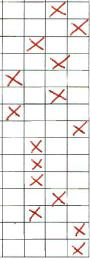

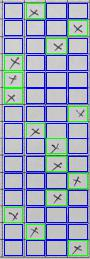

In [101]:
# image_n = read_image(0, images_n, 0.5)
# image_r = read_image(0, rotated_images, 0.5)
# image_p = read_image(0, perspective_images, 0.5)
# # show_image(warped_images[0])
# resized_n = cv.resize(image_n, (0,0), fx=0.5, fy=0.5)
# resized_r = cv.resize(image_r, (0,0), fx=0.5, fy=0.5)
# resized_p = cv.resize(image_p, (0,0), fx=0.5, fy=0.5)
# # show_image(resized)
# table1_n = get_first_grid(resized_n)
# table1_r = get_first_grid(resized_r)
# table1_p = get_first_grid(resized_p)

# table2_n = get_second_grid(resized_n)
# table2_r = get_second_grid(resized_r)
# table2_p = get_second_grid(resized_p)

# show_image(table1_n)
# # show_image(table1_r)
# # show_image(table1_p)
# # cv.imwrite('./table1_n.jpg', table1_n) 
# # show_image(table2_n)
# # show_image(table2_r)
# # show_image(table2_p)
# # show_image(table2)
# table_x1 = find_x_from_table(table1_p)
# table_x2 = find_x_from_table(table2_r)
# show_image(table_x1[1])
# # show_image(table_x2)
# # print(warped_images[0][1])